In [1]:
# Fine-tuning Phi-2 for Text Summarization on XSum - Complete Colab Notebook

## 1. Setup and Installation
# Install packages - Phi-2 requires specific versions
!pip install -q transformers>=4.35.0 datasets torch accelerate bitsandbytes einops
!pip install -q evaluate rouge_score tensorboard peft

# Check GPU - Phi-2 needs good GPU!
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("\n⚠️ Phi-2 requires 16GB+ GPU. Colab Free T4 has 15GB - may need Pro for A100")
else:
    print("❌ No GPU! This will NOT work without GPU.")

# Imports
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    TrainingArguments, Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import evaluate
from tqdm.auto import tqdm

# Create directories
for d in ['/content/notebooks', '/content/reports', '/content/checkpoints', '/content/logs']:
    os.makedirs(d, exist_ok=True)

# Set seed
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(42)

print("Setup complete!")


GPU Available: False
❌ No GPU! This will NOT work without GPU.


Setup complete!


In [2]:
# Set seed
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(42)

print("Setup complete!")


Setup complete!


In [7]:
## 2. Load XSum Dataset
# Load XSum - extreme summarization dataset
from huggingface_hub import hf_hub_download
import tarfile, os

path = hf_hub_download(
    repo_id="xsum",
    repo_type="dataset",
    filename="data/XSUM-EMNLP18-Summary-Data-Original.tar.gz"
)

extract_dir = "/content/xsum_raw"
os.makedirs(extract_dir, exist_ok=True)

with tarfile.open(path, "r:gz") as tar:
    tar.extractall(extract_dir)

print("Extracted to:", extract_dir)


data/XSUM-EMNLP18-Summary-Data-Original.(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

/tmp/ipython-input-3626324510.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_dir)


Extracted to: /content/xsum_raw


In [8]:
import os
for root, dirs, files in os.walk(extract_dir):
    print(root, len(files))
    break

/content/xsum_raw 0


In [10]:
def parse_xsum_file(path):
    with open(path, encoding="utf-8") as f:
        text = f.read()

    def get(tag):
        start = f"[SN]{tag}[SN]"
        parts = text.split(start)
        if len(parts) < 2:
            return ""
        return parts[1].strip().split("[SN]", 1)[0].strip()

    return {
        "url": get("URL"),
        "title": get("TITLE"),
        "summary": get("FIRST-SENTENCE"),
        "document": get("TITLE") + "\n" + get("RESTBODY"),
    }



In [12]:
import os
from datasets import Dataset

data_dir = "/content/xsum_raw/bbc-summary-data"  # change to your actual path

examples = []
for fname in os.listdir(data_dir):
    if fname.endswith(".summary"):
        examples.append(parse_xsum_file(os.path.join(data_dir, fname)))

print(len(examples))
print(examples[0])


237018
{'url': 'http://web.archive.org/web/20170116012142/http://www.bbc.co.uk/news/uk-england-tyne-38628461', 'title': 'Newcastle affordable homes project wins £11.8m funding', 'summary': 'A council has been awarded nearly £12m to build hundreds of new affordable homes.', 'document': 'Newcastle affordable homes project wins £11.8m funding\nNewcastle City Council intends to fund 449 properties with the allocation, which it says is the largest in the north-east of England.\nCabinet member for housing, Jane Streather, said they wanted to create "sustainable and balanced communities".\nThe different types of accommodation planned include shared ownership and rent-to-buy.\nHousing for older people and those with disabilities or other care needs are also proposed.\nThe council has prepared council-owned land for development, "encouraging investment and minimising the risk for developers", it said.\nHowever, some communities in places like High West Jesmond and Kenton have protested against 

In [13]:
dataset = Dataset.from_list(examples)
dataset

Dataset({
    features: ['url', 'title', 'summary', 'document'],
    num_rows: 237018
})

In [14]:
def length_bucket(example):
    l = len(example["document"].split())
    if l < 200:
        return "short"
    elif l < 500:
        return "medium"
    else:
        return "long"

dataset = dataset.map(lambda x: {"len_bucket": length_bucket(x)})


Map:   0%|          | 0/237018 [00:00<?, ? examples/s]

In [15]:
from collections import Counter
print(Counter(dataset["len_bucket"]))


Counter({'medium': 108338, 'long': 64691, 'short': 63989})


In [16]:
dataset = dataset.shuffle(seed=42)

In [17]:
import numpy as np
from collections import defaultdict

TARGET_TOTAL = 20_000

# Group indices by bucket
buckets = defaultdict(list)
for i, ex in enumerate(dataset):
    buckets[ex["len_bucket"]].append(i)

# Determine how many from each bucket
bucket_sizes = {k: len(v) for k, v in buckets.items()}
total = sum(bucket_sizes.values())

bucket_targets = {
    k: int(TARGET_TOTAL * v / total)
    for k, v in bucket_sizes.items()
}

bucket_targets


{'short': 5399, 'long': 5458, 'medium': 9141}

In [18]:
selected_indices = []

rng = np.random.default_rng(42)

for bucket, idxs in buckets.items():
    idxs = np.array(idxs)
    rng.shuffle(idxs)
    selected_indices.extend(idxs[:bucket_targets[bucket]])

small_dataset = dataset.select(selected_indices)
small_dataset = small_dataset.shuffle(seed=42)

print(len(small_dataset))


19998


In [21]:
N_train = 17_999
N_val = 999
N_test = 999

train = small_dataset.select(range(0, N_train))
val = small_dataset.select(range(N_train, N_train + N_val))
test = small_dataset.select(range(N_train + N_val, N_train + N_val + N_test))

from datasets import DatasetDict

dataset = DatasetDict({
    "train": train,
    "validation": val,
    "test": test,
})

dataset


DatasetDict({
    train: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 17999
    })
    validation: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 999
    })
    test: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 999
    })
})

In [22]:
print(dataset)

for split in ["train", "validation", "test"]:
    print(split, Counter(dataset[split]["len_bucket"]))


DatasetDict({
    train: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 17999
    })
    validation: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 999
    })
    test: Dataset({
        features: ['url', 'title', 'summary', 'document', 'len_bucket'],
        num_rows: 999
    })
})
train Counter({'medium': 8206, 'long': 4918, 'short': 4875})
validation Counter({'medium': 443, 'short': 282, 'long': 274})
test Counter({'medium': 492, 'long': 265, 'short': 242})



SAMPLE EXAMPLES

Example 1:

Document (163 words):
Stephen Ward denies manslaughter of baby son
Jordan Ward died after his father, Stephen, called an ambulance because his son had stopped breathing at his home in Cirencester, Gloucestershire.
Bristol Crown Court heard that medical tests concluded that Jordan's injuries were not the result of an acci...

Summary (18 words):
A father killed his nine-month-old son by violently shaking him and causing "catastrophic injuries", a court has heard.
--------------------------------------------------------------------------------

Example 2:

Document (233 words):
Samia Shahid: Uncle arrested in 'honour killing' case
Samia Shahid, 28, from Bradford, died in July in northern Punjab.
It is understood that Haq Nawaz was held by police in the Punjab city of Jhelum after an alleged attempt to prove she died of natural causes.
In a second development, the policeman...

Summary (25 words):
The uncle of a British woman who died in Pakistan in a suspect

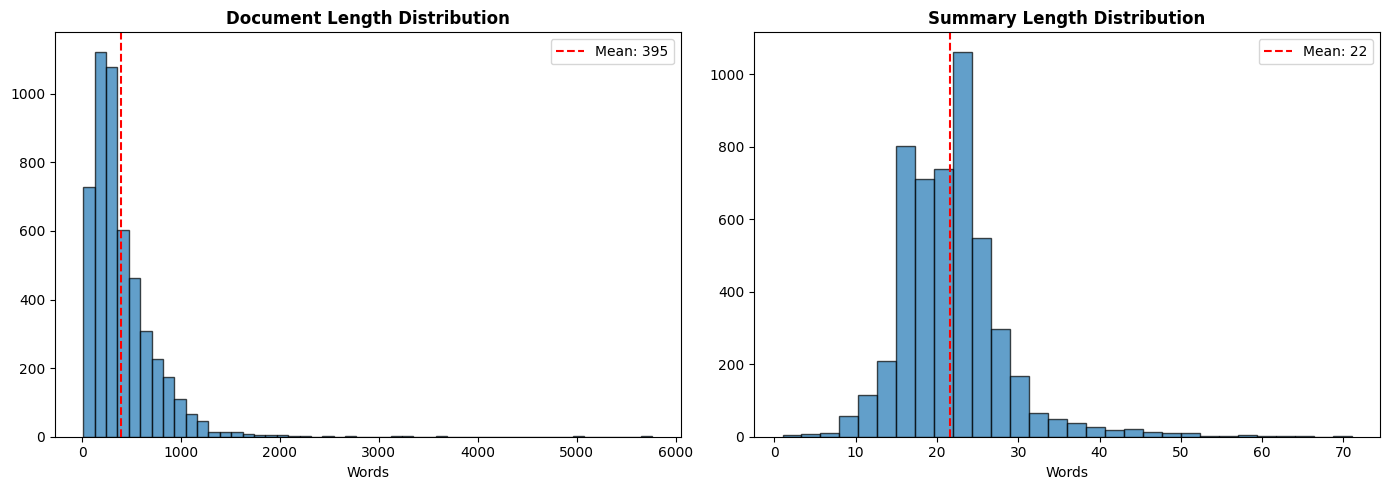


Average document: 395 words
Average summary: 22 words
Compression ratio: 18.3x


In [24]:

## 3. Explore Dataset
# Show examples
print("\n" + "="*80)
print("SAMPLE EXAMPLES")
print("="*80)

for i in range(3):
    ex = dataset['train'][i]
    print(f"\nExample {i+1}:")
    print(f"\nDocument ({len(ex['document'].split())} words):")
    print(ex['document'][:300] + "...")
    print(f"\nSummary ({len(ex['summary'].split())} words):")
    print(ex['summary'])
    print("-" * 80)

# Length analysis
doc_lengths = [len(ex['document'].split()) for ex in dataset['train'].select(range(5000))]
sum_lengths = [len(ex['summary'].split()) for ex in dataset['train'].select(range(5000))]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(doc_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Document Length Distribution', fontweight='bold')
axes[0].set_xlabel('Words')
axes[0].axvline(np.mean(doc_lengths), color='red', linestyle='--',
                label=f'Mean: {np.mean(doc_lengths):.0f}')
axes[0].legend()

axes[1].hist(sum_lengths, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Summary Length Distribution', fontweight='bold')
axes[1].set_xlabel('Words')
axes[1].axvline(np.mean(sum_lengths), color='red', linestyle='--',
                label=f'Mean: {np.mean(sum_lengths):.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('/content/reports/xsum_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nAverage document: {np.mean(doc_lengths):.0f} words")
print(f"Average summary: {np.mean(sum_lengths):.0f} words")
print(f"Compression ratio: {np.mean(doc_lengths)/np.mean(sum_lengths):.1f}x")

In [26]:
## 4. Configuration
MODEL_NAME = "microsoft/phi-2"
MAX_LENGTH = 1024        # Input: article + prompt
MAX_SUMMARY_LENGTH = 128 # Output: summary
BATCH_SIZE = 2           # Small due to 2.7B params
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3
CHECKPOINT_DIR = "/content/checkpoints"

# Use LoRA for efficient fine-tuning (otherwise OOM)
USE_LORA = True
USE_8BIT = True  # 8-bit quantization to save memory

print(f"Model: {MODEL_NAME}")
print(f"Max length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"LoRA: {USE_LORA}")
print(f"8-bit: {USE_8BIT}")

Model: microsoft/phi-2
Max length: 1024
Batch size: 2
LoRA: True
8-bit: True


In [29]:
## 5. Load Model with Quantization
# Load tokenizer
print(f"Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Tokenizer loaded. Vocab size: {tokenizer.vocab_size}")

# Quantization config for 8-bit training
if USE_8BIT:
    bnb_config = BitsAndBytesConfig(
        load_in_8bit=True,
        bnb_8bit_compute_dtype=torch.float16,
        bnb_8bit_use_double_quant=True,
    )
    print("Using 8-bit quantization")
else:
    bnb_config = None

# Load model
print(f"\nLoading {MODEL_NAME}...")
print("This may take 2-3 minutes...")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config if USE_8BIT else None,
    trust_remote_code=True,
    torch_dtype=torch.float16 if not USE_8BIT else None,
    device_map="auto"
)

print(f"Model loaded! Parameters: {model.num_parameters():,}")

# Prepare for LoRA
if USE_LORA:
    model = prepare_model_for_kbit_training(model)

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

Loading tokenizer...
Tokenizer loaded. Vocab size: 50257
Using 8-bit quantization

Loading microsoft/phi-2...
This may take 2-3 minutes...


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [ ]:

## 6. Preprocessing
# Create prompt template
def create_prompt(document, summary=None):
    """
    Format for Phi-2:
    ### Instruction: Summarize the following article in one sentence.
    ### Article: {document}
    ### Summary: {summary}
    """
    prompt = f"""### Instruction: Summarize the following article in one sentence.
### Article: {document}
### Summary:"""

    if summary:
        prompt += f" {summary}"

    return prompt

# Test prompt
test_doc = dataset['train'][0]['document'][:200]
test_sum = dataset['train'][0]['summary']
print("Sample prompt:")
print(create_prompt(test_doc, test_sum))
print("\n" + "="*80)

# Preprocessing function
def preprocess_function(examples):
    prompts = [
        create_prompt(doc, summ)
        for doc, summ in zip(examples["document"], examples["summary"])
    ]

    tokenized = tokenizer(
        prompts,
        max_length=MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )

    labels = tokenized["input_ids"].copy()

    for i, text in enumerate(prompts):
        summary_start = text.index("### Summary:") + len("### Summary:")
        prefix = text[:summary_start]
        prefix_ids = tokenizer(prefix, truncation=True, max_length=MAX_LENGTH)["input_ids"]
        labels[i][:len(prefix_ids)] = [-100] * len(prefix_ids)

    tokenized["labels"] = labels
    return tokenized


# Use subset for faster training (optional)
USE_SUBSET = True
if USE_SUBSET:
    print("Using subset for faster training...")
    train_dataset = dataset['train']
    val_dataset = dataset['validation']
else:
    train_dataset = dataset['train']
    val_dataset = dataset['validation']

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Preprocess
print("\nPreprocessing (may take 10-15 min)...")
tokenized_train = train_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing train"
)

tokenized_val = val_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=val_dataset.column_names,
    desc="Tokenizing validation"
)

print("Preprocessing complete!")


In [ ]:
## 7. Training Setup
# Load ROUGE metric
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [p.split("### Summary:")[-1].strip() for p in decoded_preds]
    decoded_labels = [l.split("### Summary:")[-1].strip() for l in decoded_labels]

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    return {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"],
    }


# Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Causal LM, not masked LM
)

# Training arguments
training_args = TrainingArguments(
    output_dir="/content/output",
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=8,  # Effective batch = 2 * 8 = 16
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=1000,
    save_steps=1000,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    fp16=not USE_8BIT,
    report_to="tensorboard",
    logging_dir="/content/logs",
    warmup_steps=500,
    seed=42,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("Trainer initialized!")

model.gradient_checkpointing_enable()


In [ ]:
## 8. Train Model
print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)
print("Expected time: 120-180 minutes on T4 GPU")
print("="*80 + "\n")

train_result = trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETED")
print("="*80)
print(f"Training loss: {train_result.training_loss:.4f}")
print(f"Runtime: {train_result.metrics['train_runtime']:.2f}s")

# Save model
trainer.save_model(CHECKPOINT_DIR)
tokenizer.save_pretrained(CHECKPOINT_DIR)
print(f"\nModel saved to {CHECKPOINT_DIR}")

In [ ]:
## 9. Evaluation
# Evaluate
print("\nEvaluating...")
eval_results = trainer.evaluate()

print("\n" + "="*80)
print("EVALUATION RESULTS")
print("="*80)
for key, value in eval_results.items():
    if 'rouge' in key:
        print(f"{key}: {value:.4f}")

# Save results
results_df = pd.DataFrame([{
    'Model': 'Phi-2',
    'ROUGE-1': eval_results.get('eval_rouge1', 0),
    'ROUGE-2': eval_results.get('eval_rouge2', 0),
    'ROUGE-L': eval_results.get('eval_rougeL', 0)
}])
results_df.to_csv('/content/reports/training_results.csv', index=False)
```

In [ ]:
## 10. Generate Summaries

# Summarization function
def generate_summary(article, max_length=128):
    """Generate summary for an article"""
    prompt = create_prompt(article)
    inputs = tokenizer(prompt, return_tensors="pt", max_length=MAX_LENGTH, truncation=True)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
          outputs = model.generate(
          **inputs,
          max_new_tokens=max_length,
          num_beams=4,
          repetition_penalty=1.2,
          length_penalty=0.8,
          early_stopping=True,
)


    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract summary (after "### Summary:")
    if "### Summary:" in generated_text:
        summary = generated_text.split("### Summary:")[-1].strip()
    else:
        summary = generated_text

    return summary

# Test on examples
print("\n" + "="*80)
print("SAMPLE SUMMARIES")
print("="*80)

test_examples = dataset['test'].select(range(5))

for i, ex in enumerate(test_examples):
    print(f"\nExample {i+1}:")
    print(f"Article: {ex['document'][:200]}...")
    print(f"\nTrue Summary: {ex['summary']}")

    generated = generate_summary(ex['document'])
    print(f"Generated Summary: {generated}")
    print("-" * 80)


In [ ]:
## 11. Interactive Inference
# Interactive mode
print("\n" + "="*80)
print("INTERACTIVE SUMMARIZATION")
print("="*80)

# Example articles to try
example_articles = [
    """Scientists have discovered a new species of deep-sea fish in the Mariana Trench.
    The fish, which has been named Pseudoliparis swirei, can survive at depths of up to 8,000 meters.
    Researchers say the discovery provides new insights into how life adapts to extreme conditions.""",

    """The government has announced a new initiative to plant one billion trees over the next decade.
    The program aims to combat climate change and increase biodiversity. Environmental groups have
    welcomed the plan but say more needs to be done to reduce carbon emissions."""
]

for i, article in enumerate(example_articles, 1):
    print(f"\nExample {i}:")
    print(f"Article: {article}")
    summary = generate_summary(article)
    print(f"Summary: {summary}\n")
    print("-" * 80)

# Custom input
print("\nEnter your own article to summarize (or 'quit' to exit):")
while True:
    user_input = input("\nArticle: ").strip()
    if user_input.lower() == 'quit':
        break
    if user_input:
        summary = generate_summary(user_input)
        print(f"Summary: {summary}")


In [ ]:
## 12. ROUGE Analysis
# Detailed ROUGE analysis on validation set
print("\nComputing detailed ROUGE scores...")

sample_val = dataset['validation'].select(range(100))
predictions = []
references = []

for ex in tqdm(sample_val, desc="Generating summaries"):
    pred = generate_summary(ex['document'])
    predictions.append(pred)
    references.append(ex['summary'])

# Compute ROUGE
rouge_scores = rouge.compute(
    predictions=predictions,
    references=references,
    use_stemmer=True
)

print("\n" + "="*80)
print("DETAILED ROUGE SCORES (100 samples)")
print("="*80)
print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")

# Save sample predictions
pred_df = pd.DataFrame({
    'True Summary': references,
    'Generated Summary': predictions
})
pred_df.to_csv('/content/reports/sample_predictions.csv', index=False)
print("\nSample predictions saved!")
```

## 13. Download Model
```python
# Zip model for download
!zip -r /content/phi2_summarization.zip /content/checkpoints/

# Uncomment to download
# from google.colab import files
# files.download('/content/phi2_summarization.zip')

print("Model zipped and ready!")
print(f"Size: {os.path.getsize('/content/phi2_summarization.zip') / 1e9:.2f} GB")